In [ ]:
# 한글 폰트를 구글 코랩에서 설치하기 위한 과정
# 런타임(세션) 다시 시작을 한 후에는 이 박스의 코드는 다시 실행하지 말고 아래의 박스부터 코드를 진행함

!apt-get update &> /dev/null
!pip install --upgrade pip

!apt -qq -y install fonts-nanum > /dev/null #  나눔폰트 설치 (한글 출력용)
!apt-get -qq install ttf-mscorefonts-installer > /dev/null # MS 기본 글꼴 설치
!sudo fc-cache -fv > /dev/null   #  폰트 캐시 초기화
!rm ~/.cache/matplotlib -rf > /dev/null  #  matplotlib 폰트 캐시 삭제

!pip install pytorch_lightning -q # “훈련 루프”를 깔끔하게 추상화해 주는 프레임워크(LightningModule에 모델·손실·옵티마이저·step 로직을 정의하고 Trainer로 학습/검증/테스트/추론, 멀티-GPU/TPU 등을 제어)
!pip install transformers -q # BERT/ELECTRA/GPT 등 사전학습(Pretrained) 모델과 토크나이저를 손쉽게 불러와 fine-tuning/추론을 돕는 라이브러리
!pip install torch -q # 텐서 연산, 자동 미분(autograd), GPU 가속, 모델/옵티마이저/데이터로더 등 딥러닝의 뼈대가 되는 라이브러리

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2




* PyTorch Lightning (pytorch_lightning as pl): PyTorch 코드를 더 구조화하고 반복 코드를 줄여주는 경량 프레임워크
* PyTorch(torch): 텐서 연산, 자동미분(autograd), GPU 활용을 지원하는 딥러닝 핵심 라이브러리
* 신경망 모듈(torch.nn as nn): 신경망을 구성하는 레이어/손실함수/컨테이너 제공
* Hugging Face Transformers (transformers) :사전학습(Pretrained)된 Transformer 계열 모델과 토크나이저를 통합 제공하여 파인튜닝을 수행하기 위한 다양한 아키텍처 지원(BERT, RoBERTa, ELECTRA 등)

In [ ]:
from tqdm import tqdm

import pytorch_lightning as pl
import torch.nn as nn
import torch

# HuggingFace에서 ELECTRA 모델과 토크나이저 불러오기
from transformers import ElectraModel # ELECTRA 아키텍처의 base Transformer(헤드 미포함). 입력 토큰에 대한 은닉표현(embedding/hidden states) 반환.
from transformers import AutoTokenizer # 모델이 문장을 이해할 수 있도로 문장을 숫자값으로 전환. 모델 이름만 주면 해당 모델에 맞는 토크나이저 클래스를 자동 가능
from transformers import AutoModel # 모델 이름만으로 적절한 베이스 모델 클래스를 자동 선택(BERT면 BertModel 등)

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'     #  나눔바른고딕 폰트 파일 경로 지정
font = fm.FontProperties(fname=fontpath, size=15)  #  해당 폰트를 matplotlib에 적용할 객체 생성
plt.rc('font', family='NanumBarunGothic')  #  전체 matplotlib 폰트를 나눔바른고딕으로 설정
%config InlineBackend.figure_format = 'retina'   #  시각화 이미지 품질을 'retina'로 설정하여 선명하게 출력

%matplotlib inline

Mounted at /content/drive


# KOTE
* KOTE는 라이브러리가 제공되지 않기 때문에 py 파일을 활용하거나 클래스나 함수를 직접 구현하는 방식으로 실행
* 입력 텍스트 ⇒ 숫자 토큰(토크나이저)
* 토큰 ⇒ 문장 표현 벡터(ELECTRA 인코더)
* 문장 벡터 ⇒ 44개 감정 점수(선형 분류기)
* 점수 ⇒ 확률(시그모이드, 다중 레이블 가정)

In [ ]:
# KOTE에서 제시한 44개 감정 라벨

LABELS = ['불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경', '기대감', '우쭐댐/무시함', '안타까움/실망', '비장함', '의심/불신', '뿌듯함', '편안/쾌적',
          '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', '즐거움/신남',
          '깨달음', '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처', '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰']

device = "cuda" if torch.cuda.is_available() else "cpu" # CUDA 사용 가능 여부에 따라 실행 장치 설정

class KOTEtagger(pl.LightningModule):  # 감정 분류 모델 클래스를 정의
    def __init__(self):  # 클래스가 생성될 때 한 번 실행되는 초기화 함수
        super().__init__()  # LightningModule의 초기화 내용도 같이 실행
        self.electra = ElectraModel.from_pretrained("beomi/KcELECTRA-base", revision='v2021').to(device)  # 텍스트 의미를 잘 담은 토큰별 은닉벡터를 얻기 위해 한국어에 맞게 사전학습된 ELECTRA 모델 불러와 지정된 디바이스(GPU/CPU)로 이동
        self.tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base", revision='v2021')  # 위 ELECTRA 모델과 호환되는 토크나이저 로드 (문자열 → 토큰 ID 변환 담당)
        self.classifier = nn.Linear(self.electra.config.hidden_size, 44).to(device)  # ELECTRA의 [CLS] 임베딩 차원(히든 크기)을 44개 감정 라벨 확률로 변환하는 선형층 정의

    def forward(self, text: str):  # 모델을 호출했을 때 실행되는 함수; 한 개의 문자열 단위로 입력됨
        encoding = self.tokenizer.encode_plus(  # 토크나이저로 텍스트를 숫자 ID로 변환하고, 패딩/마스크까지 한 번에 준비
          text,  # 분류할 원문 문자열
          add_special_tokens=True,  # 문장 앞뒤에 [CLS], [SEP] 같은 특수 토큰 자동 추가 (모델이 문장 경계 인식 가능)
          max_length=512,  # 토큰 최대 길이 제한 (너무 긴 문장은 512 토큰으로 잘림; 너무 짧은 문장은 패딩으로 채움)
          return_token_type_ids=False,  # 문장쌍 분류가 아니라서 세그먼트 ID는 사용하지 않음
          padding="max_length",  # 길이가 512가 되도록 패딩 (배치 처리 시 텐서 크기를 맞추기 위함)
          return_attention_mask=True,  # 실제 토큰과 패딩을 구분해주는 마스크도 반환 (모델이 패딩을 무시하도록)
          return_tensors='pt',  # 파이토치 텐서 형태로 반환 (바로 모델에 넣을 수 있음)
        ).to(device)  # 생성된 텐서들(input_ids, attention_mask)을 GPU/CPU로 이동

        output = self.electra(  # 사전학습 모델에 인풋 전달하여 마지막 히든 스테이트(각 토큰 임베딩) 얻기
            encoding["input_ids"],  # 토큰 ID 텐서
            attention_mask=encoding["attention_mask"]  # 패딩 위치를 0으로 하여 모델이 무시하게 함
        )
        output = output.last_hidden_state[:, 0, :]  # 배치의 각 문장에서 첫 번째 토큰([CLS]) 위치의 임베딩만 추출 (문장 대표 벡터)
        output = self.classifier(output)  # [CLS] 임베딩을 선형층에 통과시켜 44차원 로짓(각 감정 라벨의 점수)으로 변환
        output = torch.sigmoid(output)  # 다중 레이블 분류이므로 각 라벨에 대해 독립 확률(0~1)로 해석하기 위해 시그모이드 적용
        torch.cuda.empty_cache()  # (선택) GPU 메모리 캐시를 비워 메모리 부족 문제를 완화 (빈번 호출은 성능에 영향 가능)

        return output  # 크기: (배치크기, 44) 의 텐서 반환. 한 문장만 넣었으니 (1, 44). 각 값은 해당 감정 라벨의 확률

# 학습된 가중치를 불러와 즉시 예측 가능한 모델 객체 생성
trained_model = KOTEtagger()  # 위에서 정의한 모델 클래스 인스턴스화 (백본+분류기 구조만 포함, 아직 가중치는 랜덤)
trained_model.load_state_dict(  # 학습이 완료된 파라미터(가중치)를 파일에서 읽어와 모델에 로드
    torch.load("/content/drive/MyDrive/CLASS/202502_NLP/강의 코드 및 슬라이드/kote_pytorch_lightning.bin"),  # 구글 드라이브에 저장된 체크포인트 경로
    strict=False  # 레이어 이름/개수가 조금 달라도 가능한 항목만 로드(미스매치가 있어도 최대한 불러오도록)
)  # 이 시점부터 trained_model은 학습된 상태로 텍스트 입력 시 바로 감정 확률을 출력할 수 있음


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

_IncompatibleKeys(missing_keys=[], unexpected_keys=['electra.embeddings.position_ids'])

In [ ]:
preds = trained_model("재미있어요! 재미는 확실히 있는데 뭐랄까... 너무 정신없달까...ㅋㅋ")[0]

for l, p in zip(LABELS, preds):
    if p>0.4:
        print(f"{l}: {p}")

불평/불만: 0.667758584022522
안타까움/실망: 0.7538663744926453
짜증: 0.400044709444046
어이없음: 0.4546275734901428
즐거움/신남: 0.8438082933425903
당황/난처: 0.5778809189796448
재미없음: 0.4866366684436798
기쁨: 0.4820347726345062


In [ ]:
# 원본 파일 준비

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/사회적논란여부 및 아티스트 특성(20250904).csv', encoding='utf-8', lineterminator='\n')

df

,Unnamed: 0,artist,month,title,content,논란여부,논란유형,date,ip,like,...,upcdi_cn,reconsump_cn,ureconsump_cn,wuemr,wemr,emprate,new_dc_post,new_dc_view,new_dc_recom,new_dc_uid\r
0,0,2NE1,2010-10,공지. 친목질 하지마,특히 교무실 드립 어쩌구 하는애들 알았지? 어서 친목질이야 ㅋㅋㅋ,0,마약,2010-10-12 00:00:00,NaN,0.0,...,18779.0,10845.0,17119.0,6.29,58.64,59.5,4887.0,1883248.0,410.0,3240\r
1,1,2NE1,2010-10,조공북..희망사항..,희망사항은 백만개지만...짤로 만드는건 어렵긔....ㅋ,0,마약,2010-10-12 00:00:00,NaN,0.0,...,18779.0,10845.0,17119.0,6.29,58.64,59.5,4887.0,1883248.0,410.0,3240\r
2,2,2NE1,2010-10,박봄.swf,,0,마약,2010-10-12 00:00:00,NaN,0.0,...,18779.0,10845.0,17119.0,6.29,58.64,59.5,4887.0,1883248.0,410.0,3240\r
3,3,B.A.P,NaT,멋찬 와꾸도 젤루한테 발리고 무쓸모 맞는것같은데,얼빠급식들 빨던게 젤루잖어,0,성범죄,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r
4,4,EXO-K,2014-06,어른유글은 다 신고삭제잼 ㅋㅋㅋㅋ,그래봐야 어른유가 남자들한테 아닌척 꼬리치는 상여우인거는 유명함,1,스캔들,2014-06-19 00:00:00,223.620,5.0,...,28844.0,17680.0,25264.0,5.97,58.11,61.2,7710.0,2574410.0,5403.0,2838\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1045,티파니 (TIFFANY),2014-04,이런 짤도 좋아여,From DC Wave,0,스캔들,2014-04-04 00:00:00,NaN,0.0,...,28844.0,17680.0,25264.0,5.97,58.11,60.9,6866.0,1385407.0,8813.0,4199\r
1046,1046,티파니 (TIFFANY),2014-04,콩콩콩콩,From DC Wave,0,스캔들,2014-04-04 00:00:00,NaN,0.0,...,28844.0,17680.0,25264.0,5.97,58.11,60.9,6866.0,1385407.0,8813.0,4199\r
1047,1047,티파니 (TIFFANY),2014-04,파니야 지금 어때..,난 지금 되게 뭔가 힘들다...ㅎㅎ.... 내가 지금 뭘해야할지 도통 제대로 감잡...,0,스캔들,2014-04-04 00:00:00,NaN,1.0,...,28844.0,17680.0,25264.0,5.97,58.11,60.9,6866.0,1385407.0,8813.0,4199\r
1048,1048,포미닛(4Minute),2013-06,에핑 나머지 멤버빠들도 진짜 불쌍하지 않냐?,버블팝 트메하는 동안 손가락만 빨고있는 포퀴들 보는거같다,0,태도논란,2013-06-16 00:00:00,NaN,NaN,...,26467.0,15998.0,23386.0,6.11,58.22,60.8,3261.0,544801.0,934.0,1908\r


In [ ]:
neg_p = []  # 부정 감정 평균 점수 저장 리스트
pos_p = []  # 긍정 감정 평균 점수 저장 리스트
mean_p = []  # 전체 감정 점수 평균 저장 리스트
labels = []  # 감지된 감정 레이블 저장 리스트
values = []  # 감정 점수 저장 리스트

# 감정 라벨 분류: 긍정/부정/중립
pos = ['환영/호의', '감동/감탄', '고마움', '존경', '기대감', '뿌듯함', '편안/쾌적', '신기함/관심', '아껴주는', '즐거움/신남', '흐뭇함(귀여움/예쁨)', '행복', '기쁨', '안심/신뢰']
neg = ['불평/불만', '지긋지긋', '슬픔', '화남/분노', '안타까움/실망', '의심/불신', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', '어이없음',
       '패배/자기혐오', '귀찮음', '힘듦/지침', '죄책감', '증오/혐오', '당황/난처', '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '불안/걱정']
neu = ['우쭐댐/무시함', '비장함', '없음', '깨달음', '놀람']

# 전체 텍스트에 대해 감정 추론 수행
for text in tqdm(df['title']):
    preds = trained_model(text)[0]  # 감정 예측 확률 반환
    test = []  # 감지된 감정 레이블 저장
    test1 = []  # 해당 감정의 예측 점수 저장
    test2 = []  # 긍/부/중립에 따라 점수 조정하여 저장

    # 예측된 감정 중 threshold(0.4) 이상인 항목만 저장
    for label, value in zip(LABELS, preds):
        if value>0.4:
            test.append(label)
            test1.append(round(value.item(), 2))
    labels.append(test)

    # 감정 라벨 분류별 점수 부여: 부정은 음수, 긍정은 양수, 중립은 0
    for l, s in zip(test, test1):
        if l in neg:
            test2.append(s * -1)
        elif l in neu:
            test2.append(0)
        elif l in pos:
            test2.append(s)
    values.append(test2)

    # 긍정 및 부정 점수 분리
    positive_numbers = []
    negative_numbers = []

    for num in test2:
        if num > 0:
            positive_numbers.append(num)
        elif num < 0:
            negative_numbers.append(num)

    # 각 감정 점수 평균값 계산 (감정 없을 경우 0 처리)
    try:
        positive = round(sum(positive_numbers) / len(positive_numbers), 3)
        pos_p.append(positive)
    except:
        positive = 0
        pos_p.append(positive)
    try:
        negative = round(sum(negative_numbers) / len(negative_numbers), 3)
        neg_p.append(negative)
    except:
        negative = 0
        neg_p.append(negative)

    mean_p.append(round(positive + negative, 3))

100%|██████████| 1050/1050 [36:03<00:00,  2.06s/it]


In [ ]:
df['Sentiment_label'] = [', '.join(map(str, lst)) for lst in labels]
df['Sentiment_values'] = [', '.join(map(str, lst)) for lst in values]
df['Sentiment_pos'] = pos_p
df['Sentiment_neg'] = neg_p
df['Sentiment_mean'] = mean_p

In [ ]:
df['Sentiment_pos'] = pd.to_numeric(df['Sentiment_pos'], errors='coerce')
df['Sentiment_neg'] = pd.to_numeric(df['Sentiment_neg'], errors='coerce')

test_pos  = df.groupby('month')['Sentiment_pos'].mean()
test_neg = df.groupby('month')['Sentiment_neg'].mean()

In [ ]:
# 감성분석 점수 df 저장하기

# df.to_csv('/content/drive/MyDrive/Colab Notebooks/사회적논란여부 및 아티스트 특성(20250904) v2.csv', encoding='utf-8', index=False)

/tmp/ipython-input-1582859328.py:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


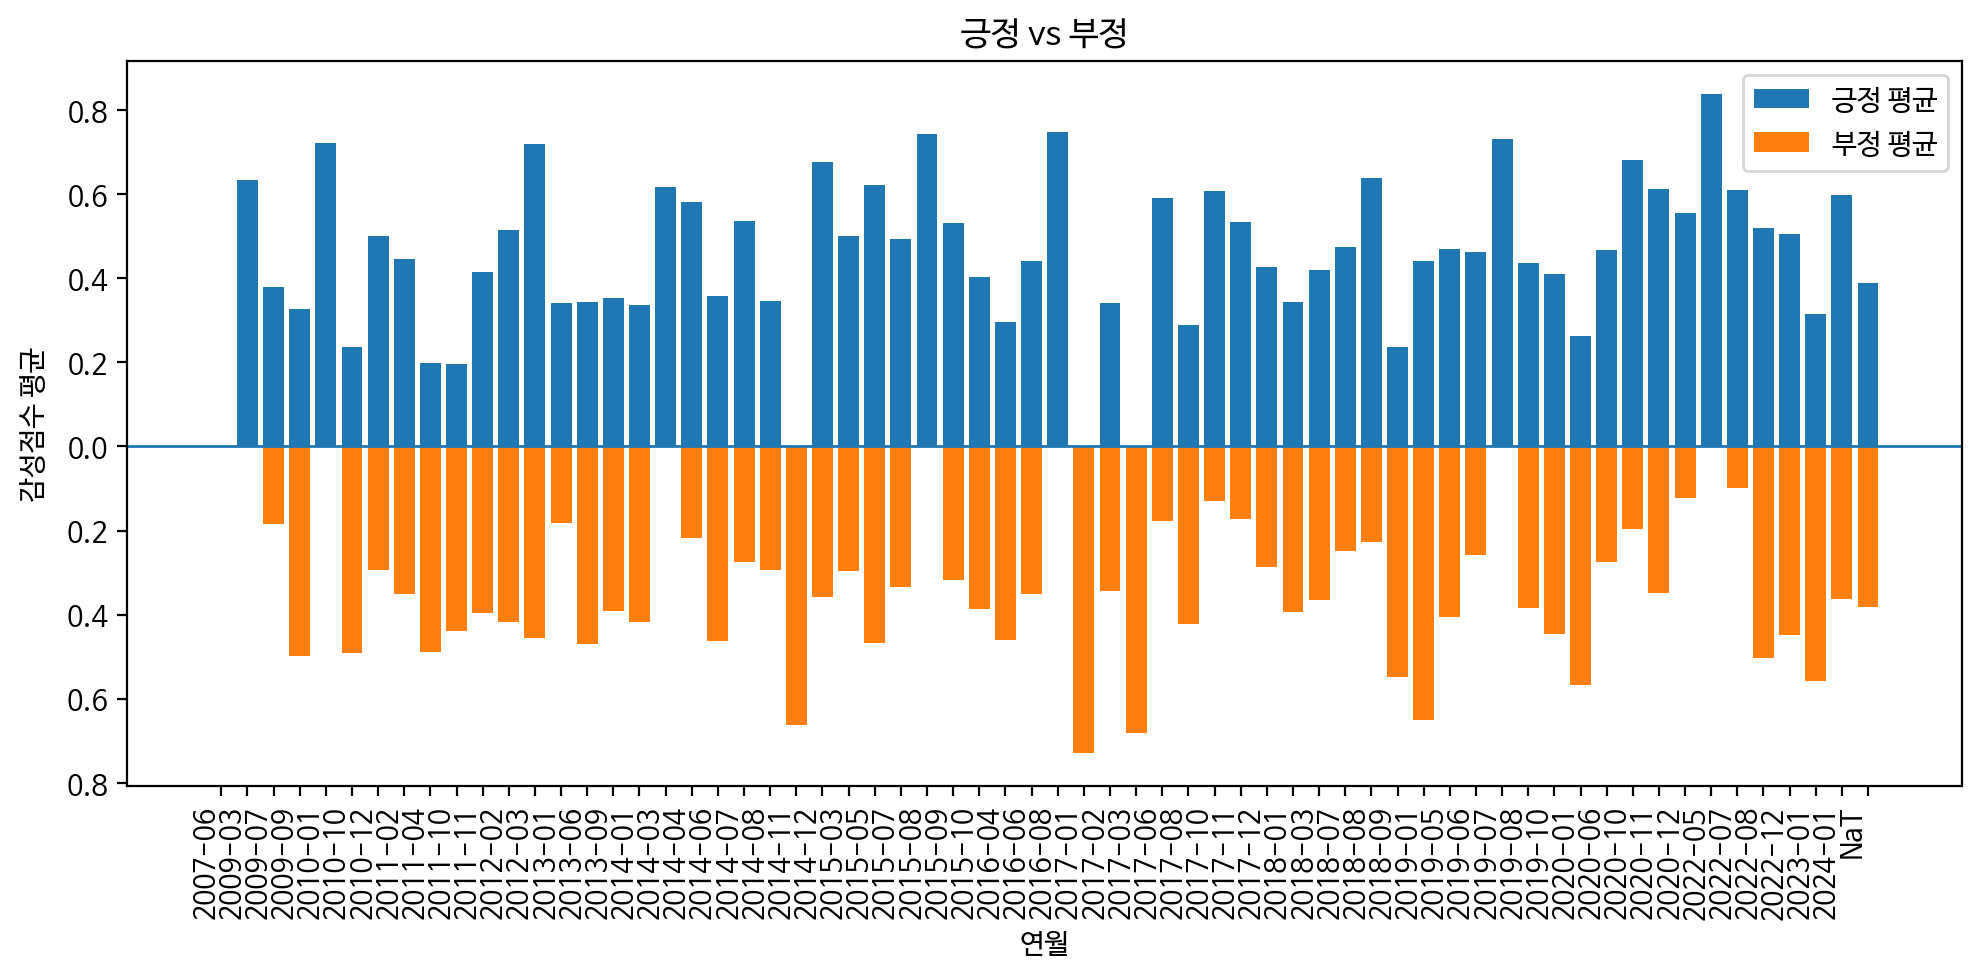

In [ ]:
months = sorted(set(test_pos.index).union(set(test_neg.index)))
pos = pd.Series(test_pos).reindex(months).fillna(0.0)
neg = pd.Series(test_neg).reindex(months).fillna(0.0)

# 부정값이 양수(크기)로 되어 있다면 아래로 내려가도록 부호 반전
neg_plot = (-neg) if (neg >= 0).all() else neg

plt.figure(figsize=(10,5))
plt.bar(months, pos.values, label='긍정 평균')
plt.bar(months, neg_plot.values, label='부정 평균')  # 음수면 아래로 그려짐
plt.axhline(0, linewidth=1)  # 기준선
plt.xlabel('연월')
plt.ylabel('감성점수 평균')
plt.title('긍정 vs 부정')
plt.xticks(months, rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Multilingual Sentiment Classification Model (23 Languages)
* This model is a fine-tuned version of distilbert/distilbert-base-multilingual-cased for multilingual sentiment analysis. It leverages synthetic data from multiple sources to achieve robust performance across different languages and cultural contexts.
* Base Model: distilbert/distilbert-base-multilingual-cased
* Task: Text Classification (Sentiment Analysis)
* Languages: Supports English plus Chinese (中文), Spanish (Español), Hindi (हिन्दी), Arabic (العربية), Bengali (বাংলা), Portuguese (Português), Russian (Русский), Japanese (日本語), German (Deutsch), Malay (Bahasa Melayu), Telugu (తెలుగు), Vietnamese (Tiếng Việt), Korean (한국어), French (Français), Turkish (Türkçe), Italian (Italiano), Polish (Polski), Ukrainian (Українська), Tagalog, Dutch (Nederlands), Swiss German (Schweizerdeutsch), and Swahili.
Number of Classes: 5 (Very Negative, Negative, Neutral, Positive, Very Positive)

* https://huggingface.co/tabularisai/multilingual-sentiment-analysis


In [11]:
# Multilingual Sentiment Classification Model in HuggingFace 테스트하기

from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="tabularisai/multilingual-sentiment-analysis",
    top_k=None,                 # 모든 클래스 점수 보고 싶으면 사용 (또는 return_all_scores=True)
)

texts = [
    "이 가게의 케이크는 정말 맛있어요!",
    "서비스가 너무 별로였어요.",
    "날씨가 그저 그렇네요."
]

# 출력 구조 확인하기
for t in texts:
    print(pipe(t))

Device set to use cpu


[[{'label': 'Positive', 'score': 0.6602522730827332}, {'label': 'Very Positive', 'score': 0.28061985969543457}, {'label': 'Very Negative', 'score': 0.021331416442990303}, {'label': 'Neutral', 'score': 0.0190673116594553}, {'label': 'Negative', 'score': 0.01872917450964451}]]
[[{'label': 'Negative', 'score': 0.8582382798194885}, {'label': 'Very Negative', 'score': 0.08742809295654297}, {'label': 'Positive', 'score': 0.019663983955979347}, {'label': 'Neutral', 'score': 0.018736373633146286}, {'label': 'Very Positive', 'score': 0.015933357179164886}]]
[[{'label': 'Neutral', 'score': 0.498786062002182}, {'label': 'Negative', 'score': 0.3349924385547638}, {'label': 'Positive', 'score': 0.08411531895399094}, {'label': 'Very Negative', 'score': 0.056336548179388046}, {'label': 'Very Positive', 'score': 0.025769582018256187}]]


In [12]:
# 가장 높은 값과 라벨만
for t in texts:
    scores = pipe(t)[0]                # 5개 라벨의 점수 리스트
    best = max(scores, key=lambda x: x["score"])
    print(f"{best['label']} ({best['score']:.4f}) | {t}")

Positive (0.6603) | 이 가게의 케이크는 정말 맛있어요!
Negative (0.8582) | 서비스가 너무 별로였어요.
Neutral (0.4988) | 날씨가 그저 그렇네요.
